# 20 Pytorch Lightning

In [7]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [70]:
import pytorch_lightning as pl 
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

In [57]:
input_size = 784
hidden_size = 100
num_classes = 10 
nepochs = 2
batch_size = 100
lr = 0.001

In [4]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True,
                                           transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False,
                                           transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                           shuffle=False)

In [5]:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


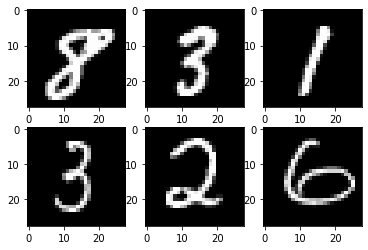

In [6]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [73]:
class LitNeuralNet(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LitNeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.reshape(-1, 28 * 28)

        # Forward pass
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        self.logger.experiment.add_scalar('train_loss', loss, self.global_step)
        return {"loss": loss, 'log': tensorboard_logs}

    # define what happens for testing here

    def train_dataloader(self):
        # MNIST dataset
        train_dataset = torchvision.datasets.MNIST(
            root="./data", train=True, transform=transforms.ToTensor(), download=True
        )
        # Data loader
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=False
        )
        return train_loader

    def val_dataloader(self):
        test_dataset = torchvision.datasets.MNIST(
            root="./data", train=False, transform=transforms.ToTensor()
        )

        test_loader = torch.utils.data.DataLoader(
            dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False
        )
        return test_loader
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.reshape(-1, 28 * 28)

        # Forward pass
        outputs = self(images)
                        
        loss = F.cross_entropy(outputs, labels)
        return {"val_loss": loss}
    
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        self.logger.experiment.add_scalar('avg_val_loss', avg_loss, self.global_step)
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [75]:
model = LitNeuralNet(input_size, hidden_size, num_classes)

In [76]:
logger = TensorBoardLogger('tb_logs')
trainer = Trainer(max_epochs=nepochs, logger=logger)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 78.5 K
1 | relu | ReLU   | 0     
2 | l2   | Linear | 1.0 K 
--------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [77]:
from tensorboard import notebook

notebook.display(height=500)

Selecting TensorBoard with logdir tb_logs (started 0:03:37 ago; port 6006, pid 52435).


In [ ]:
model = LitNeuralNet(input_size, hidden_size, num_classes)

trainer = Trainer(max_epochs=nepochs, auto_lr_find=True)
trainer.fit(model)

In [78]:
with torch.no_grad():
    correct = 0
    samples = 0 
    for images, labels in test_loader:
        images = images.reshape(-1, 784)
        pred = model(images)
        
        _, predictions = torch.max(pred, 1)
        samples += labels.shape[0]
        correct += (predictions == labels).sum().item()

In [79]:
print(f'Test acurracy: {correct / samples * 100:.2f}%')

Test acurracy: 95.03%



+ ```gpus=8```
+ ```fast_dev_run=True``` -> runs single batch through training and validation
+ ```train_percent_check=0.1``` -> train only on 10% of data

+ ```logger = TensorBoardLogger('tb_logs')```
        
#### Advanced features
+ distributed_backend
+ (DDP) implements data parallelism at the module level which can run across multiple machines.
+ 16 bit precision
+ log_gpu_memory
+ TPU support

+ `auto_lr_find`: automatically finds a good learning rate before training
+ ```deterministic```: makes training reproducable
+ ```gradient_clip_val```: 0 default